# Miniproject 1: Image Classification

## Introduction

### Important dates:

- Project release: Friday, 15th March 2019
- **Submission deadline**: Monday, 29th April 2019, 11:59 pm

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://yann.lecun.com/exdb/mnist/). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used as a first test for new classification algorithms. 
We follow this tradition to investigate the performance of artificial neural networks of different complexity on MNIST. However, since MNIST is too easy for accessing the full power of modern machine learning algorithms (see e.g. [this post](https://twitter.com/goodfellow_ian/status/852591106655043584)) we will extend our analysis to the recently introduced, harder [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/). Feel free to gain inspiration from the [Keras example directory](https://github.com/keras-team/keras/tree/master/examples) for your implementations.
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "convolutional neural network", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night (or on an external server).

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. Provide clear and concise answers respecting the indicated maximum length (answers to the questions should be below the line that says "Answer to question ...").

**The submitted notebook must be run by you!** We will only do random tests of your code and not re-run the full notebook. There will be fraud detection sessions at the end of the semester.

### Your names

**Before you start**: please enter your full name(s) in the field below.

In [24]:
student1 = 'Martin Esguerra'
student2 = 'Franck Dessimoz'

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [25]:
%matplotlib inline

import time
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras import optimizers
from keras import regularizers
from keras import backend as K
from keras.models import Sequential
from keras.optimizers import SGD, Adam
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization

### Plotting

In [26]:
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 28, ydim = 28,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    fig.set_size_inches(14, 6)
    ax1.plot(history.history['loss'], label = 'training')
    ax1.plot(history.history['val_loss'], label = 'validation')
    ax2.plot(history.history['acc'], label = 'training')
    ax2.plot(history.history['val_acc'], label = 'validation')
    finalize_standardplot(fig, ax1, ax2)
    return fig

## Exercise 1: Data import and visualization (4 points)

### Description

### Loading the data

The datasets we use in this project (MNIST, Fashion-MNIST) consists of grayscale images with 28x28 pixels. Keras comes with a convenient in-built [data importer](https://keras.io/datasets/) for common datasets.

1. As a warm-up exercise, use this importer to (down-)load the MNIST and Fashion-MNIST dataset. Assign useful variables to test & train images and labels for both datasets respectively. (2 pts)
2. Use the corresponding plotting function defined above to plot some samples of the two datasets. What do the green digits at the bottom left of each image indicate? (1 sentence max.) (2 pts)

The low resolution (and grayscale) of the images certainly misses some information that could be helpful for classifying the images. However, since the data has lower dimensionality due to the low resolution, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish.



### Solution

#### Question 1.

In [27]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test) = fashion_mnist.load_data()

#### Question 2.

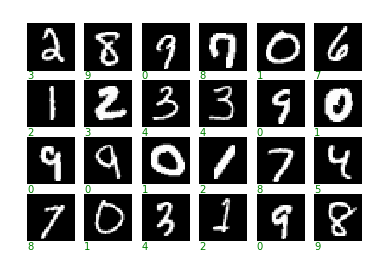

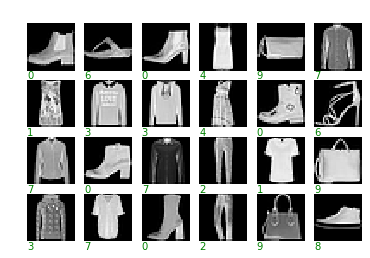

In [28]:
plot_some_samples(x_train, y_train)
plot_some_samples(x_fashion_train, y_fashion_train);

Answer to question 2:

The green digits at the bottom left of each image indicate the prediction class it should be made.

**Data pre-processing**: To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing). Furthermore we reshape (flatten) the input images to input vectors and rescale the data into the range [0,1].

In [29]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

y_fashion_train = keras.utils.to_categorical(y_fashion_train)
y_fashion_test = keras.utils.to_categorical(y_fashion_test)

In [30]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])/np.max(x_train)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])/np.max(x_test)

x_fashion_train = x_fashion_train.reshape(x_fashion_train.shape[0],
                                          x_fashion_train.shape[1]*x_fashion_train.shape[2])/np.max(x_fashion_train)
x_fashion_test = x_fashion_test.reshape(x_fashion_test.shape[0],
                                        x_fashion_test.shape[1]*x_fashion_test.shape[2])/np.max(x_fashion_test)

## Exercise 2: No hidden layer (10 points)

### Description

Define and fit a model without a hidden layer (since we will use multi-layer models later in this project, you can define a general constructor function for models with an arbitrary number of hidden layers already at this point). (1 pt for each step)

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices)`. Explain the green and red digits at the bottom of each image.
9. Repeat the above steps for fitting the network to the Fashion-MNIST dataset.


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

#### Questions 1. to 6.

After some parameter testing more than 10 epochs is unnecessary.

In [31]:
# Initialize the model
model = Sequential()

# Input layer/output layer
model.add(Dense(10, activation='softmax', input_shape=(784,)))

# Set up the model
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model to MNIST
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 30us/step - loss: 1.3062 - acc: 0.6873 - val_loss: 0.8189 - val_acc: 0.8303
Epoch 2/10
60000/60000 [==============================] - 1s 22us/step - loss: 0.7203 - acc: 0.8394 - val_loss: 0.6096 - val_acc: 0.8629
Epoch 3/10
60000/60000 [==============================] - 1s 22us/step - loss: 0.5891 - acc: 0.8586 - val_loss: 0.5269 - val_acc: 0.8737
Epoch 4/10
60000/60000 [==============================] - 1s 22us/step - loss: 0.5268 - acc: 0.8685 - val_loss: 0.4810 - val_acc: 0.8795
Epoch 5/10
60000/60000 [==============================] - 1s 22us/step - loss: 0.4889 - acc: 0.8749 - val_loss: 0.4513 - val_acc: 0.8852
Epoch 6/10
60000/60000 [==============================] - 1s 22us/step - loss: 0.4630 - acc: 0.8799 - val_loss: 0.4295 - val_acc: 0.8886
Epoch 7/10
60000/60000 [==============================] - 1s 22us/step - loss: 0.4437 - acc: 0.8834 - val_loss: 0.4135 - val_acc

#### Question 7.

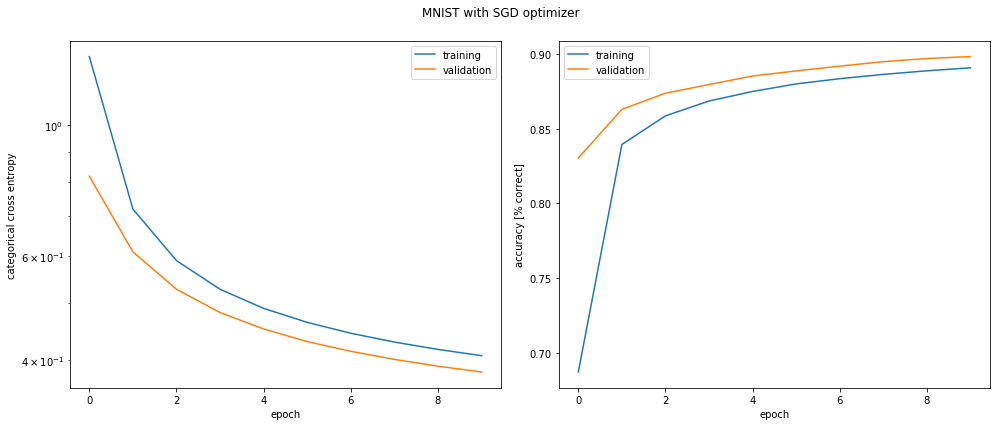

In [32]:
plot_history(history, "MNIST with SGD optimizer");

#### Question 8.

In [33]:
trained_preds = np.round(model.predict(x_test))
indices = (trained_preds == y_test)
errors = []
for i in range(indices.shape[0]):
    if not all(indices[i]):
        errors.append(i)

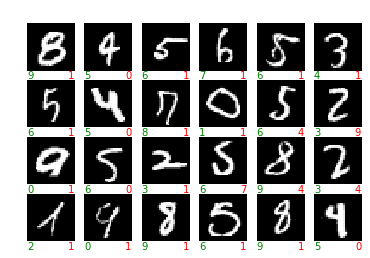

In [34]:
plot_some_samples(x_test, y_test, trained_preds, errors);

Answer to question 10:

We can see the different missclassifications, it occurs with numbers that have an odd shape, and the number the model predicts ressembles the image

#### Question 9.

In [35]:
# Fit the model to fashion_MNIST
history_fashion = model.fit(x_fashion_train, y_fashion_train, epochs=10, batch_size=128,
                            validation_data=(x_fashion_test, y_fashion_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 25us/step - loss: 1.6547 - acc: 0.4552 - val_loss: 1.0197 - val_acc: 0.6509
Epoch 2/10
60000/60000 [==============================] - 1s 21us/step - loss: 0.8979 - acc: 0.6913 - val_loss: 0.8278 - val_acc: 0.7142
Epoch 3/10
60000/60000 [==============================] - 1s 21us/step - loss: 0.7708 - acc: 0.7350 - val_loss: 0.7454 - val_acc: 0.7420
Epoch 4/10
60000/60000 [==============================] - 1s 21us/step - loss: 0.7056 - acc: 0.7595 - val_loss: 0.6964 - val_acc: 0.7603
Epoch 5/10
60000/60000 [==============================] - 1s 21us/step - loss: 0.6634 - acc: 0.7750 - val_loss: 0.6632 - val_acc: 0.7729
Epoch 6/10
60000/60000 [==============================] - 1s 21us/step - loss: 0.6336 - acc: 0.7858 - val_loss: 0.6392 - val_acc: 0.7806
Epoch 7/10
60000/60000 [==============================] - 1s 21us/step - loss: 0.6108 - acc: 0.7939 - val_loss: 0.6204 - val_acc

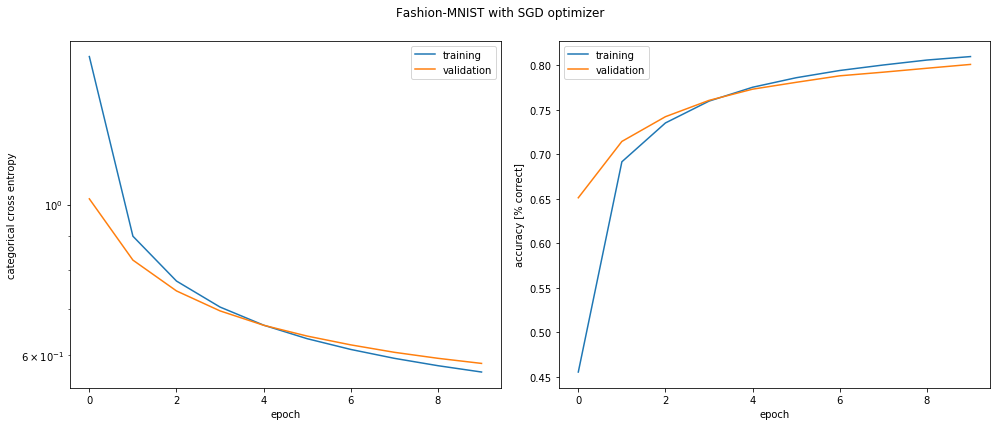

In [36]:
plot_history(history_fashion, "Fashion-MNIST with SGD optimizer");

In [37]:
trained_preds = np.round(model.predict(x_fashion_test))
indices = (trained_preds == y_fashion_test)
errors = []
for i in range(indices.shape[0]):
    if not all(indices[i]):
        errors.append(i)

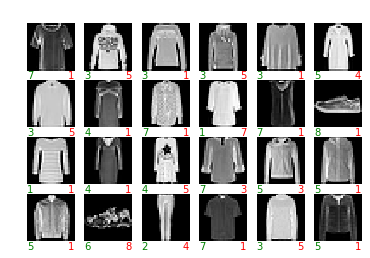

In [38]:
plot_some_samples(x_fashion_test, y_fashion_test, trained_preds, errors);

For fashion mnist we can also that the missclassified images ressemble the category that was picked by the classifier. The classifier found features of a particular category to make the decision

## Exercise 3: One hidden layer, different optizimizers & overfitting (10 points)

### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 128 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to display your model in a compact way. (1 pt)
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent (SGD). (1pt)
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam). (1pt)
4. Plot the learning curves of SGD with a reasonable learning rate (i.e. in the range [0.01,0.1]) together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot. (2pts)
5. Answer the questions below. (4pts)
6. Run the network (using the Adam optimizer) on the Fashion-MNIST dataset and plot the learning curves using the plot_history function defined above. (1pt)

### Solution

#### Question 1.

In [39]:
# Initialize the model
model_2 = Sequential()

# Input layer - 1 hidden layer with 128 hidden neurons
model_2.add(Dense(128, activation='relu', input_shape=(784,)))

# Output layer
model_2.add(Dense(10, activation='softmax'))

In [40]:
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


#### Question 2.

In [41]:
learning_rates = [0.1, 0.3, 0.5, 0.7, 0.9]

for lr in learning_rates:
    print("Learning rate: {}".format(lr))
    # Set up the model with SGD and learning rate = lr
    sgd = optimizers.SGD(lr=lr)
    model_2.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Fit the model to MNIST
    history_sgd = model_2.fit(x_train, y_train, epochs=50, batch_size=128, validation_data=(x_test, y_test))

Learning rate: 0.1
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 43us/step - loss: 0.4722 - acc: 0.8752 - val_loss: 0.2736 - val_acc: 0.9257
Epoch 2/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.2546 - acc: 0.9282 - val_loss: 0.2212 - val_acc: 0.9373
Epoch 3/50
60000/60000 [==============================] - 2s 35us/step - loss: 0.2059 - acc: 0.9421 - val_loss: 0.1831 - val_acc: 0.9473
Epoch 4/50
60000/60000 [==============================] - 2s 35us/step - loss: 0.1744 - acc: 0.9515 - val_loss: 0.1686 - val_acc: 0.9526
Epoch 5/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.1517 - acc: 0.9579 - val_loss: 0.1486 - val_acc: 0.9573
Epoch 6/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.1347 - acc: 0.9621 - val_loss: 0.1335 - val_acc: 0.9614
Epoch 7/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.1210 - acc: 0.9660 - val_los

60000/60000 [==============================] - 2s 34us/step - loss: 0.0086 - acc: 0.9991 - val_loss: 0.0691 - val_acc: 0.9809
Epoch 10/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.0076 - acc: 0.9993 - val_loss: 0.0756 - val_acc: 0.9799
Epoch 11/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.0071 - acc: 0.9995 - val_loss: 0.0730 - val_acc: 0.9796
Epoch 12/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.0065 - acc: 0.9995 - val_loss: 0.0713 - val_acc: 0.9811
Epoch 13/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.0060 - acc: 0.9996 - val_loss: 0.0724 - val_acc: 0.9809
Epoch 14/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.0056 - acc: 0.9996 - val_loss: 0.0737 - val_acc: 0.9804
Epoch 15/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.0052 - acc: 0.9997 - val_loss: 0.0719 - val_acc: 0.9814
Epoch 16/50
60000/60000 [=====================

Epoch 18/50
60000/60000 [==============================] - 2s 33us/step - loss: 7.9276e-04 - acc: 1.0000 - val_loss: 0.0857 - val_acc: 0.9810
Epoch 19/50
60000/60000 [==============================] - 2s 34us/step - loss: 7.7630e-04 - acc: 1.0000 - val_loss: 0.0856 - val_acc: 0.9814
Epoch 20/50
60000/60000 [==============================] - 2s 33us/step - loss: 7.5790e-04 - acc: 1.0000 - val_loss: 0.0859 - val_acc: 0.9808
Epoch 21/50
60000/60000 [==============================] - 2s 34us/step - loss: 7.4134e-04 - acc: 1.0000 - val_loss: 0.0860 - val_acc: 0.9814
Epoch 22/50
60000/60000 [==============================] - 2s 33us/step - loss: 7.1951e-04 - acc: 1.0000 - val_loss: 0.0861 - val_acc: 0.9808
Epoch 23/50
60000/60000 [==============================] - 2s 34us/step - loss: 7.0249e-04 - acc: 1.0000 - val_loss: 0.0857 - val_acc: 0.9813
Epoch 24/50
60000/60000 [==============================] - 2s 33us/step - loss: 6.9445e-04 - acc: 1.0000 - val_loss: 0.0868 - val_acc: 0.9810
Epoch 

60000/60000 [==============================] - 2s 34us/step - loss: 2.8426e-04 - acc: 1.0000 - val_loss: 0.0948 - val_acc: 0.9808
Epoch 26/50
60000/60000 [==============================] - 2s 33us/step - loss: 2.7991e-04 - acc: 1.0000 - val_loss: 0.0947 - val_acc: 0.9812
Epoch 27/50
60000/60000 [==============================] - 2s 34us/step - loss: 2.7653e-04 - acc: 1.0000 - val_loss: 0.0949 - val_acc: 0.9810
Epoch 28/50
60000/60000 [==============================] - 2s 34us/step - loss: 2.7213e-04 - acc: 1.0000 - val_loss: 0.0945 - val_acc: 0.9810
Epoch 29/50
60000/60000 [==============================] - 2s 33us/step - loss: 2.6866e-04 - acc: 1.0000 - val_loss: 0.0958 - val_acc: 0.9811
Epoch 30/50
60000/60000 [==============================] - 2s 34us/step - loss: 2.6534e-04 - acc: 1.0000 - val_loss: 0.0947 - val_acc: 0.9812
Epoch 31/50
60000/60000 [==============================] - 2s 34us/step - loss: 2.6095e-04 - acc: 1.0000 - val_loss: 0.0955 - val_acc: 0.9812
Epoch 32/50
60000/

60000/60000 [==============================] - 2s 39us/step - loss: 1.4236e-04 - acc: 1.0000 - val_loss: 0.1010 - val_acc: 0.9810
Epoch 33/50
60000/60000 [==============================] - 2s 37us/step - loss: 1.4149e-04 - acc: 1.0000 - val_loss: 0.1010 - val_acc: 0.9809
Epoch 34/50
60000/60000 [==============================] - 2s 36us/step - loss: 1.3979e-04 - acc: 1.0000 - val_loss: 0.1007 - val_acc: 0.9810
Epoch 35/50
60000/60000 [==============================] - 2s 37us/step - loss: 1.3852e-04 - acc: 1.0000 - val_loss: 0.1014 - val_acc: 0.9810
Epoch 36/50
60000/60000 [==============================] - 2s 35us/step - loss: 1.3711e-04 - acc: 1.0000 - val_loss: 0.1013 - val_acc: 0.9811
Epoch 37/50
60000/60000 [==============================] - 2s 34us/step - loss: 1.3569e-04 - acc: 1.0000 - val_loss: 0.1011 - val_acc: 0.9811
Epoch 38/50
60000/60000 [==============================] - 2s 34us/step - loss: 1.3457e-04 - acc: 1.0000 - val_loss: 0.1016 - val_acc: 0.9811
Epoch 39/50
60000/

#### Queston 3.

In [42]:
# Initialize the model
model_2 = Sequential()

# Input layer - 1 hidden layer with 128 hidden neurons
model_2.add(Dense(128, activation='relu', input_shape=(784,)))

# Output layer
model_2.add(Dense(10, activation='softmax'))

# Set up the model with adam optimizer
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model to MNIST
history_adam = model_2.fit(x_train, y_train, epochs=50, batch_size=128, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 65us/step - loss: 0.3600 - acc: 0.9005 - val_loss: 0.1991 - val_acc: 0.9427
Epoch 2/50
60000/60000 [==============================] - 3s 53us/step - loss: 0.1665 - acc: 0.9529 - val_loss: 0.1369 - val_acc: 0.9597
Epoch 3/50
60000/60000 [==============================] - 3s 51us/step - loss: 0.1180 - acc: 0.9664 - val_loss: 0.1113 - val_acc: 0.9672
Epoch 4/50
60000/60000 [==============================] - 3s 50us/step - loss: 0.0917 - acc: 0.9731 - val_loss: 0.1031 - val_acc: 0.9687
Epoch 5/50
60000/60000 [==============================] - 3s 50us/step - loss: 0.0734 - acc: 0.9790 - val_loss: 0.0882 - val_acc: 0.9726
Epoch 6/50
60000/60000 [==============================] - 3s 50us/step - loss: 0.0609 - acc: 0.9826 - val_loss: 0.0864 - val_acc: 0.9745
Epoch 7/50
60000/60000 [==============================] - 3s 50us/step - loss: 0.0519 - acc: 0.9854 - val_loss: 0.0782 - val_acc

#### Question 4.

In [43]:
# Initialize the model
model_2 = Sequential()

# Input layer - 1 hidden layer with 128 hidden neurons
model_2.add(Dense(128, activation='relu', input_shape=(784,)))

# Output layer
model_2.add(Dense(10, activation='softmax'))

# Set up the model with SGD optimizer and learning rate = 0.01
sgd = optimizers.SGD(lr=0.01)
model_2.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model to MNIST
history_sgd = model_2.fit(x_train, y_train, epochs=50, batch_size=128, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 48us/step - loss: 1.1063 - acc: 0.7407 - val_loss: 0.6094 - val_acc: 0.8625
Epoch 2/50
60000/60000 [==============================] - 2s 40us/step - loss: 0.5326 - acc: 0.8682 - val_loss: 0.4453 - val_acc: 0.8862
Epoch 3/50
60000/60000 [==============================] - 2s 40us/step - loss: 0.4319 - acc: 0.8856 - val_loss: 0.3856 - val_acc: 0.8975
Epoch 4/50
60000/60000 [==============================] - 2s 36us/step - loss: 0.3866 - acc: 0.8941 - val_loss: 0.3535 - val_acc: 0.9035
Epoch 5/50
60000/60000 [==============================] - 2s 35us/step - loss: 0.3592 - acc: 0.9003 - val_loss: 0.3331 - val_acc: 0.9088
Epoch 6/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.3399 - acc: 0.9050 - val_loss: 0.3181 - val_acc: 0.9104
Epoch 7/50
60000/60000 [==============================] - 2s 35us/step - loss: 0.3252 - acc: 0.9087 - val_loss: 0.3051 - val_acc

In [44]:
# This plotting routine might help you ...
def comparison_plot(history_sgd, history_adam, label1, label2, title):
    fig, ax1, ax2 = prepare_standardplot(title, "epochs")
    fig.set_size_inches(14, 6)
    ax1.plot(history_sgd.history['loss'], label=label1 + ' training')
    ax1.plot(history_sgd.history['val_loss'], label=label1 + ' validation')
    ax1.plot(history_adam.history['loss'], label=label2 + ' training')
    ax1.plot(history_adam.history['val_loss'], label=label2 + ' validation')
    ax2.plot(history_sgd.history['acc'], label=label1 + ' training')
    ax2.plot(history_sgd.history['val_acc'], label=label1 + ' validation')
    ax2.plot(history_adam.history['acc'], label=label2 + ' training')
    ax2.plot(history_adam.history['val_acc'], label=label2 + ' validation')
    finalize_standardplot(fig, ax1, ax2)
    return fig

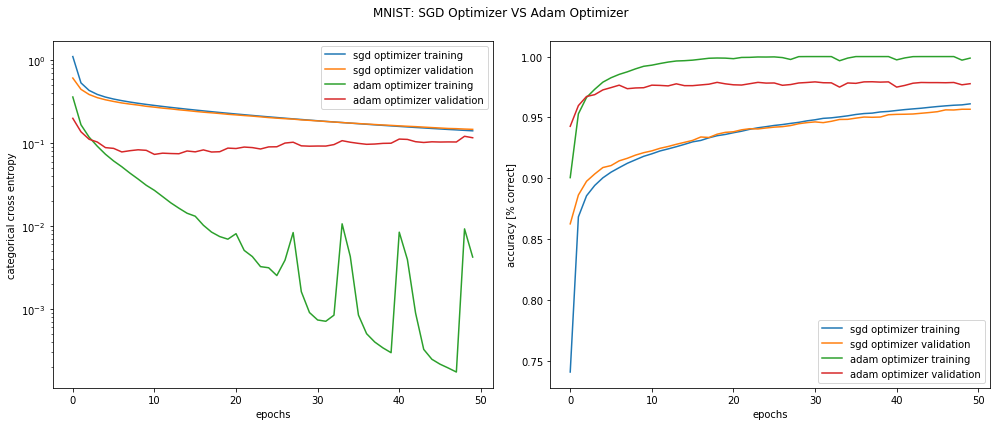

In [45]:
comparison_plot(history_sgd, history_adam, 'sgd optimizer', 'adam optimizer', 'MNIST: SGD Optimizer VS Adam Optimizer');

#### Question 5.

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence each (double click this markdown cell to edit).

**Answer**:

A) When the learning reate is very large the weights are updated more drastically from iteration to iteration and model might not converge to optimal value

B) If the learning rate is very slow a lot of iterations are needed to find the optimal weight values, the convergence rate is fairly slow.

**Question**: At which epoch (approximately) does the Adam optimizer start to overfit (on MNIST)? Please answer with one full sentence.

**Answer**:
At epoch number 10-11 approximately, the validation loss does not improve anymore. We can see in the graph the elbow curve

**Question**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**:
The loss curve reaches a minimum and then starts to grow again (on validation set) while the accuracy reaches a maximum and then worsens

#### Question 6.

In [46]:
# Initialize the model
model_2 = Sequential()

# Input layer - 1 hidden layer with 128 hidden neurons
model_2.add(Dense(128, activation='relu', input_shape=(784,)))

# Output layer
model_2.add(Dense(10, activation='softmax'))

# Set up the model with adam optimizer
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model to MNIST
history_adam_fashion = model_2.fit(x_fashion_train, y_fashion_train, epochs=50, batch_size=128,
                           validation_data=(x_fashion_test, y_fashion_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 66us/step - loss: 0.5596 - acc: 0.8083 - val_loss: 0.4551 - val_acc: 0.8416
Epoch 2/50
60000/60000 [==============================] - 3s 50us/step - loss: 0.4075 - acc: 0.8563 - val_loss: 0.4477 - val_acc: 0.8381
Epoch 3/50
60000/60000 [==============================] - 3s 54us/step - loss: 0.3702 - acc: 0.8692 - val_loss: 0.3971 - val_acc: 0.8560
Epoch 4/50
60000/60000 [==============================] - 3s 57us/step - loss: 0.3382 - acc: 0.8799 - val_loss: 0.4013 - val_acc: 0.8585
Epoch 5/50
60000/60000 [==============================] - 3s 56us/step - loss: 0.3216 - acc: 0.8850 - val_loss: 0.3739 - val_acc: 0.8681
Epoch 6/50
60000/60000 [==============================] - 4s 61us/step - loss: 0.3058 - acc: 0.8895 - val_loss: 0.3589 - val_acc: 0.8708
Epoch 7/50
60000/60000 [==============================] - 3s 53us/step - loss: 0.2930 - acc: 0.8942 - val_loss: 0.3618 - val_acc

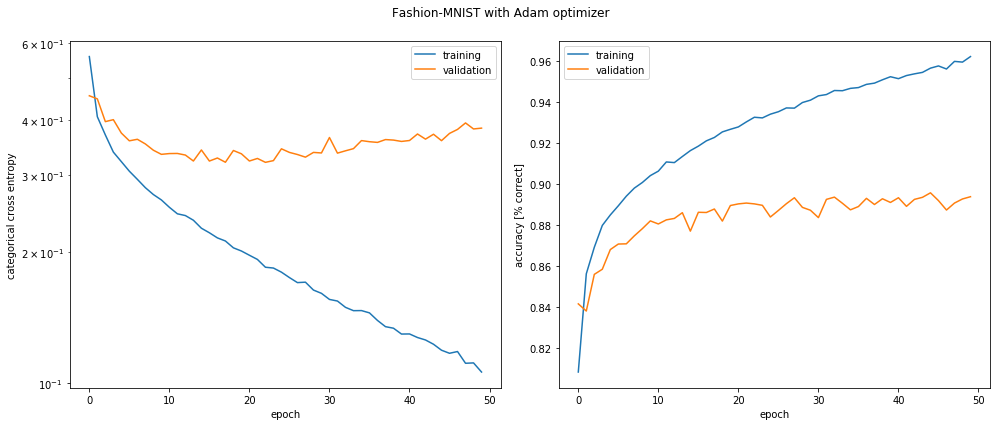

In [47]:
plot_history(history_adam_fashion, "Fashion-MNIST with Adam optimizer");

## Exercise 4: Model performance as a function of number of hidden neurons (8 points)

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models (e.g. 5) with different hidden layer sizes (between 10 and 1000 hidden neurons) to the MNIST dataset. You may use the Adam optimizer and a meaningful number of epochs (overfitting!). (3 pts)
2. Plot the best validation loss and accuracy versus the number of hidden neurons. Is the observed trend in accordance with the [general approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem)? If not, what might be practical reasons for the deviation? (2 sentences max.) (3 pts)
3. Repeat steps 1. & 2. for the Fashion-MNIST dataset. (2 pts)

In this exercise we fit each model only for one initialization and random seed. In practice one would collect some statistics (e.g. 25-, 50-, 75-percentiles) for each layer size by fitting each model several times with different initializations and the random seeds. You may also want to do this here. It is a good exercise, but not mandatory as it takes quite a bit of computation time.

### Solution

#### Question 1 and 2

Model creation

In [48]:
def compute_model(neurons, x_tr, x_te, y_tr, y_te):
    # Initialize the model
    model_3 = Sequential()

    # Input layer - 1 hidden layer with 10 hidden neurons
    model_3.add(Dense(neurons, activation='relu', input_shape=(784,)))

    # Output layer
    model_3.add(Dense(10, activation='softmax'))

    # Set up the model
    model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Fit the model to MNIST
    history_adam = model_3.fit(x_tr, y_tr, epochs=15, batch_size=128, validation_data=(x_te, y_te))
    
    return np.min(history_adam.history["val_loss"])

Model training

In [49]:
num_neurons = [10, 100, 500, 700, 1000]

In [50]:
loss_per_neurons = []
for neurons in num_neurons:
    loss_per_neurons.append(compute_model(neurons, x_train, x_test, y_train, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 3s 43us/step - loss: 0.7763 - acc: 0.7799 - val_loss: 0.3963 - val_acc: 0.8942
Epoch 2/15
60000/60000 [==============================] - 2s 27us/step - loss: 0.3596 - acc: 0.9013 - val_loss: 0.3178 - val_acc: 0.9121
Epoch 3/15
60000/60000 [==============================] - 2s 27us/step - loss: 0.3088 - acc: 0.9137 - val_loss: 0.2911 - val_acc: 0.9169
Epoch 4/15
60000/60000 [==============================] - 2s 26us/step - loss: 0.2867 - acc: 0.9195 - val_loss: 0.2810 - val_acc: 0.9219
Epoch 5/15
60000/60000 [==============================] - 2s 28us/step - loss: 0.2731 - acc: 0.9236 - val_loss: 0.2706 - val_acc: 0.9218
Epoch 6/15
60000/60000 [==============================] - 2s 32us/step - loss: 0.2645 - acc: 0.9267 - val_loss: 0.2654 - val_acc: 0.9230
Epoch 7/15
60000/60000 [==============================] - 2s 32us/step - loss: 0.2573 - acc: 0.9281 - val_loss: 0.2607 - val_acc

60000/60000 [==============================] - 7s 116us/step - loss: 0.0043 - acc: 0.9988 - val_loss: 0.0877 - val_acc: 0.9797
Epoch 15/15
60000/60000 [==============================] - 7s 116us/step - loss: 0.0081 - acc: 0.9974 - val_loss: 0.0847 - val_acc: 0.9795
Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 10s 172us/step - loss: 0.2377 - acc: 0.9314 - val_loss: 0.1169 - val_acc: 0.9668
Epoch 2/15
60000/60000 [==============================] - 9s 154us/step - loss: 0.0921 - acc: 0.9729 - val_loss: 0.0759 - val_acc: 0.9767
Epoch 3/15
60000/60000 [==============================] - 9s 155us/step - loss: 0.0576 - acc: 0.9830 - val_loss: 0.0696 - val_acc: 0.9775
Epoch 4/15
60000/60000 [==============================] - 9s 153us/step - loss: 0.0399 - acc: 0.9878 - val_loss: 0.0680 - val_acc: 0.9791
Epoch 5/15
60000/60000 [==============================] - 9s 154us/step - loss: 0.0277 - acc: 0.9919 - val_loss: 0.0696 - val_acc: 

In [51]:
loss_per_neurons_fashion = []
for neurons in num_neurons:
    loss_per_neurons_fashion.append(compute_model(neurons, x_fashion_train, x_fashion_test,
                                    y_fashion_train, y_fashion_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 3s 47us/step - loss: 0.9004 - acc: 0.6894 - val_loss: 0.6161 - val_acc: 0.7904
Epoch 2/15
60000/60000 [==============================] - 2s 27us/step - loss: 0.5435 - acc: 0.8158 - val_loss: 0.5387 - val_acc: 0.8181
Epoch 3/15
60000/60000 [==============================] - 2s 27us/step - loss: 0.4921 - acc: 0.8329 - val_loss: 0.5173 - val_acc: 0.8235
Epoch 4/15
60000/60000 [==============================] - 2s 27us/step - loss: 0.4663 - acc: 0.8401 - val_loss: 0.4871 - val_acc: 0.8310
Epoch 5/15
60000/60000 [==============================] - 2s 27us/step - loss: 0.4482 - acc: 0.8453 - val_loss: 0.4830 - val_acc: 0.8321
Epoch 6/15
60000/60000 [==============================] - 2s 27us/step - loss: 0.4355 - acc: 0.8502 - val_loss: 0.4718 - val_acc: 0.8374
Epoch 7/15
60000/60000 [==============================] - 2s 27us/step - loss: 0.4250 - acc: 0.8533 - val_loss: 0.4629 - val_acc

60000/60000 [==============================] - 7s 117us/step - loss: 0.1937 - acc: 0.9275 - val_loss: 0.3169 - val_acc: 0.8917
Epoch 15/15
60000/60000 [==============================] - 7s 116us/step - loss: 0.1860 - acc: 0.9306 - val_loss: 0.3163 - val_acc: 0.8921
Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 12s 195us/step - loss: 0.4951 - acc: 0.8251 - val_loss: 0.4177 - val_acc: 0.8530
Epoch 2/15
60000/60000 [==============================] - 9s 155us/step - loss: 0.3647 - acc: 0.8695 - val_loss: 0.3786 - val_acc: 0.8662
Epoch 3/15
60000/60000 [==============================] - 9s 155us/step - loss: 0.3216 - acc: 0.8830 - val_loss: 0.3588 - val_acc: 0.8694
Epoch 4/15
60000/60000 [==============================] - 9s 156us/step - loss: 0.2971 - acc: 0.8905 - val_loss: 0.3497 - val_acc: 0.8720
Epoch 5/15
60000/60000 [==============================] - 9s 155us/step - loss: 0.2809 - acc: 0.8966 - val_loss: 0.3347 - val_acc: 

In [52]:
def plot_loss_neur(loss_per_neurons, num_neurons, title):
    plt.figure(figsize=(12,8))
    plt.title(title)
    plt.plot(num_neurons, loss_per_neurons)
    plt.xlabel("Number of neurons", fontsize=12)
    plt.ylabel("Validation Loss", fontsize=12)
    plt.show()

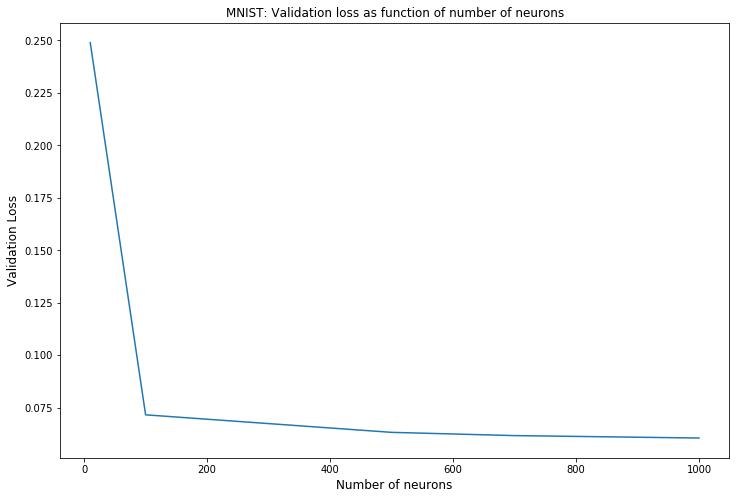

In [53]:
plot_loss_neur(loss_per_neurons, num_neurons, "MNIST: Validation loss as function of number of neurons")

Answer to question 2:

The best number of hidden neurons appears to be 500, this is not in accordance with the approximation as more hidden neurons should give a better result. One way of explaining this, would be by realizing that the function we are trying to recreate is probably not a "nice" function, it might jump around, have large gaps, etc. We can also explain this by noting that after a certain number of neurons, the additional ones do not help improve the representation

#### Question 3.

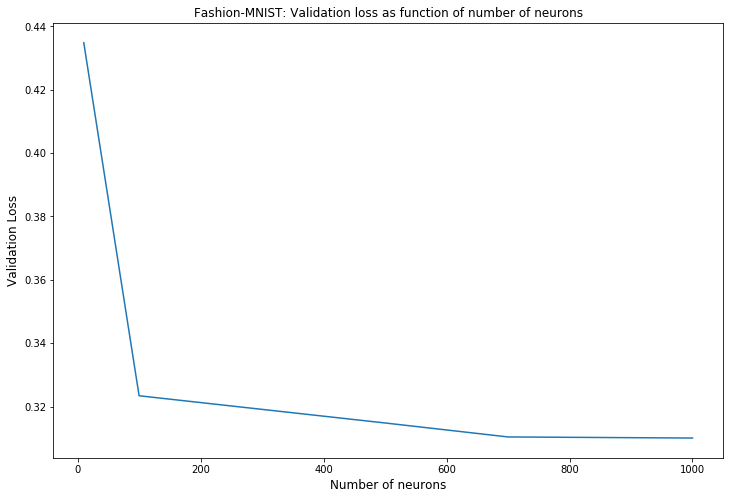

In [54]:
plot_loss_neur(loss_per_neurons_fashion, num_neurons,
               "Fashion-MNIST: Validation loss as function of number of neurons")

In the case of the fashion-MNIST we can see that the best number of neurons is 500, once again more neurons does not mean more accuracy. Here we difference between the validation loss between models with a lot of neurons is negligable again

## Exercise 5: Going deeper: tricks and regularization (8 points)

### Description

Adding hidden layers to a deep network does not necessarily lead to a straight-forward improvement of performance. Overfitting can be counteracted with regularization and dropout. Batch normalization is supposed to mainly speed up convergence. Since the MNIST dataset is almost perfectly solved already by a one-hidden-layer network we use the Fashion-MNIST dataset in this exercise.

1. Add one or two hidden layers with 50 hidden neurons (each) and train the network for a sufficiently long time (at least 100 epochs). Since deep models are very expressive you will most probably encounter overfitting. Try to improve the best validation scores of the model (even if it is only a minor improvement) by experimenting with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases. (4 pts)
2. After you have found good settings, plot the learning curves for both models, naive (=no tricks/regularization) and tuned (=tricks + regularized), preferably together in a comparison plot. Discuss your results; refer to the model performance with only 1 hidden layer. (2 sentences max.) (2pts)
3. Fit your best performing (probably regularized deep) model also to MNIST for having a reference for the next exercise. Plot the resulting learning curves. (2 pts)

### Solution

#### Question 1.

In [55]:
# Define the parameters
n_epochs = 150

No tricks/regularization

In [56]:
# Initialize the model
model_4 = Sequential()

# Input layer - First hidden layer with 50 hidden neurons
model_4.add(Dense(50, activation='relu', input_shape=(784,)))

# Second hidden layer with 50 hidden neurons
model_4.add(Dense(50))

# Output layer
model_4.add(Dense(10, activation='softmax'))

# Set up the model
model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model to fashion_MNIST
history_adam_fashion = model_4.fit(x_fashion_train, y_fashion_train, epochs=n_epochs,
                                   batch_size=128, validation_data=(x_fashion_test, y_fashion_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/150
60000/60000 [==============================] - 4s 67us/step - loss: 0.5901 - acc: 0.7952 - val_loss: 0.5194 - val_acc: 0.8062
Epoch 2/150
60000/60000 [==============================] - 3s 43us/step - loss: 0.4214 - acc: 0.8517 - val_loss: 0.4392 - val_acc: 0.8452
Epoch 3/150
60000/60000 [==============================] - 3s 42us/step - loss: 0.3853 - acc: 0.8639 - val_loss: 0.4142 - val_acc: 0.8544
Epoch 4/150
60000/60000 [==============================] - 3s 42us/step - loss: 0.3596 - acc: 0.8726 - val_loss: 0.3967 - val_acc: 0.8616
Epoch 5/150
60000/60000 [==============================] - 3s 42us/step - loss: 0.3431 - acc: 0.8768 - val_loss: 0.4250 - val_acc: 0.8465
Epoch 6/150
60000/60000 [==============================] - 3s 42us/step - loss: 0.3277 - acc: 0.8821 - val_loss: 0.3700 - val_acc: 0.8695
Epoch 7/150
60000/60000 [==============================] - 3s 42us/step - loss: 0.3156 - acc: 0.8861 - val_loss: 0.3799 - 

60000/60000 [==============================] - 3s 42us/step - loss: 0.1455 - acc: 0.9446 - val_loss: 0.4536 - val_acc: 0.8786
Epoch 60/150
60000/60000 [==============================] - 3s 42us/step - loss: 0.1459 - acc: 0.9450 - val_loss: 0.4375 - val_acc: 0.8830
Epoch 61/150
60000/60000 [==============================] - 3s 42us/step - loss: 0.1415 - acc: 0.9471 - val_loss: 0.4837 - val_acc: 0.8753
Epoch 62/150
60000/60000 [==============================] - 3s 42us/step - loss: 0.1449 - acc: 0.9452 - val_loss: 0.4842 - val_acc: 0.8738
Epoch 63/150
60000/60000 [==============================] - 3s 42us/step - loss: 0.1420 - acc: 0.9469 - val_loss: 0.4650 - val_acc: 0.8769
Epoch 64/150
60000/60000 [==============================] - 3s 42us/step - loss: 0.1411 - acc: 0.9480 - val_loss: 0.4608 - val_acc: 0.8760
Epoch 65/150
60000/60000 [==============================] - 3s 42us/step - loss: 0.1377 - acc: 0.9482 - val_loss: 0.4685 - val_acc: 0.8799
Epoch 66/150
60000/60000 [==============

Epoch 118/150
60000/60000 [==============================] - 3s 42us/step - loss: 0.0943 - acc: 0.9647 - val_loss: 0.6370 - val_acc: 0.8771
Epoch 119/150
60000/60000 [==============================] - 3s 43us/step - loss: 0.0943 - acc: 0.9655 - val_loss: 0.6209 - val_acc: 0.8711
Epoch 120/150
60000/60000 [==============================] - 3s 43us/step - loss: 0.0960 - acc: 0.9651 - val_loss: 0.6156 - val_acc: 0.8762
Epoch 121/150
60000/60000 [==============================] - 3s 43us/step - loss: 0.0929 - acc: 0.9657 - val_loss: 0.6318 - val_acc: 0.8732
Epoch 122/150
60000/60000 [==============================] - 3s 42us/step - loss: 0.0947 - acc: 0.9648 - val_loss: 0.6572 - val_acc: 0.8707
Epoch 123/150
60000/60000 [==============================] - 3s 43us/step - loss: 0.0949 - acc: 0.9651 - val_loss: 0.6553 - val_acc: 0.8677
Epoch 124/150
60000/60000 [==============================] - 3s 43us/step - loss: 0.0897 - acc: 0.9668 - val_loss: 0.6541 - val_acc: 0.8693
Epoch 125/150
60000/

In [57]:
print("The best validation score is: {:.4f}".format(np.max(history_adam_fashion.history['val_acc'])))
print("The mean validation score is: {:.4f}".format(np.mean(history_adam_fashion.history['val_acc'])))

The best validation score is: 0.8846
The mean validation score is: 0.8739


Combining everything together - tricks/regularization

In [58]:
# Define the parameters
l1 = 0.0001
l2 = 0.0001
rate = 0.20

In [59]:
# Initialize the model
model_4 = Sequential()

# Input layer
model_4.add(BatchNormalization())
model_4.add(Dense(50, activation='relu', input_shape=(784,)))
model_4.add(Dropout(rate=rate))

# Hidden layer with 50 hidden neurons
model_4.add(BatchNormalization())
model_4.add(Dense(50, kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                  bias_regularizer=regularizers.l1_l2(l1=l1, l2=l2)))
model_4.add(Dropout(rate=rate))

# Output layer
model_4.add(BatchNormalization())
model_4.add(Dense(10, activation='softmax'))

# Set up the model
model_4.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model to fashion_MNIST
history_adam_fashion_tricks = model_4.fit(x_fashion_train, y_fashion_train, epochs=n_epochs, batch_size=128,
                           validation_data=(x_fashion_test, y_fashion_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/150
60000/60000 [==============================] - 10s 162us/step - loss: 0.6735 - acc: 0.7803 - val_loss: 0.4805 - val_acc: 0.8375
Epoch 2/150
60000/60000 [==============================] - 6s 101us/step - loss: 0.4924 - acc: 0.8393 - val_loss: 0.4363 - val_acc: 0.8560
Epoch 3/150
60000/60000 [==============================] - 6s 101us/step - loss: 0.4462 - acc: 0.8509 - val_loss: 0.4156 - val_acc: 0.8638
Epoch 4/150
60000/60000 [==============================] - 6s 101us/step - loss: 0.4199 - acc: 0.8601 - val_loss: 0.4028 - val_acc: 0.8621
Epoch 5/150
60000/60000 [==============================] - 6s 101us/step - loss: 0.3996 - acc: 0.8672 - val_loss: 0.3876 - val_acc: 0.8669
Epoch 6/150
60000/60000 [==============================] - 6s 101us/step - loss: 0.3855 - acc: 0.8702 - val_loss: 0.3889 - val_acc: 0.8670
Epoch 7/150
60000/60000 [==============================] - 6s 102us/step - loss: 0.3772 - acc: 0.8712 - val_loss: 0

60000/60000 [==============================] - 6s 99us/step - loss: 0.2567 - acc: 0.9076 - val_loss: 0.3718 - val_acc: 0.8798
Epoch 60/150
60000/60000 [==============================] - 6s 100us/step - loss: 0.2541 - acc: 0.9087 - val_loss: 0.3811 - val_acc: 0.8815
Epoch 61/150
60000/60000 [==============================] - 6s 100us/step - loss: 0.2513 - acc: 0.9101 - val_loss: 0.3723 - val_acc: 0.8805
Epoch 62/150
60000/60000 [==============================] - 6s 99us/step - loss: 0.2541 - acc: 0.9091 - val_loss: 0.3835 - val_acc: 0.8792
Epoch 63/150
60000/60000 [==============================] - 6s 100us/step - loss: 0.2531 - acc: 0.9091 - val_loss: 0.3707 - val_acc: 0.8826
Epoch 64/150
60000/60000 [==============================] - 6s 100us/step - loss: 0.2537 - acc: 0.9086 - val_loss: 0.3689 - val_acc: 0.8835
Epoch 65/150
60000/60000 [==============================] - 6s 100us/step - loss: 0.2529 - acc: 0.9100 - val_loss: 0.3765 - val_acc: 0.8776
Epoch 66/150
60000/60000 [=========

60000/60000 [==============================] - 8s 135us/step - loss: 0.2304 - acc: 0.9173 - val_loss: 0.4043 - val_acc: 0.8793
Epoch 118/150
60000/60000 [==============================] - 8s 128us/step - loss: 0.2308 - acc: 0.9174 - val_loss: 0.4017 - val_acc: 0.8818
Epoch 119/150
60000/60000 [==============================] - 8s 126us/step - loss: 0.2276 - acc: 0.9187 - val_loss: 0.3895 - val_acc: 0.8808
Epoch 120/150
60000/60000 [==============================] - 6s 106us/step - loss: 0.2266 - acc: 0.9186 - val_loss: 0.3901 - val_acc: 0.8815
Epoch 121/150
60000/60000 [==============================] - 6s 104us/step - loss: 0.2264 - acc: 0.9182 - val_loss: 0.3931 - val_acc: 0.8804
Epoch 122/150
60000/60000 [==============================] - 6s 108us/step - loss: 0.2298 - acc: 0.9180 - val_loss: 0.3913 - val_acc: 0.8806
Epoch 123/150
60000/60000 [==============================] - 6s 108us/step - loss: 0.2268 - acc: 0.9187 - val_loss: 0.3911 - val_acc: 0.8794
Epoch 124/150
60000/60000 [

In [60]:
print("The best validation score is: {:.4f}".format(np.max(history_adam_fashion_tricks.history['val_acc'])))
print("The mean validation score is: {:.4f}".format(np.mean(history_adam_fashion_tricks.history['val_acc'])))

The best validation score is: 0.8852
The mean validation score is: 0.8785


#### Question 2.

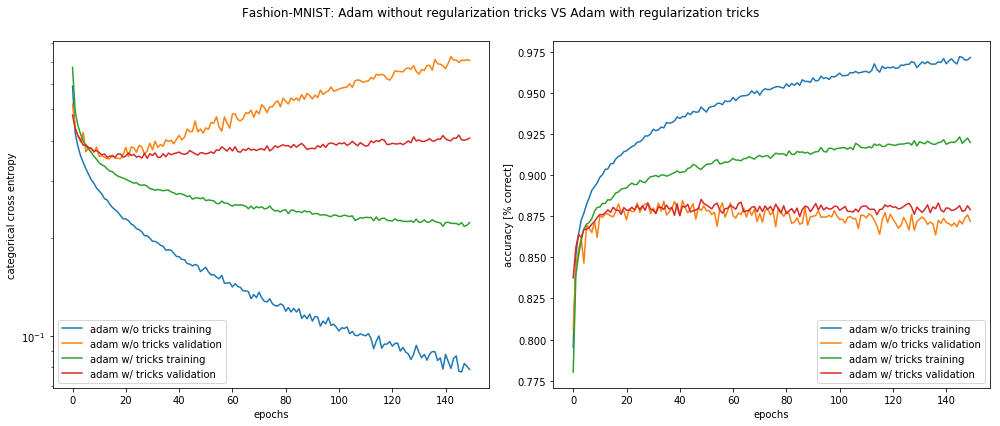

In [61]:
comparison_plot(history_adam_fashion, history_adam_fashion_tricks, 'adam w/o tricks',
    'adam w/ tricks', 'Fashion-MNIST: Adam without regularization tricks VS Adam with regularization tricks');

Answer to question 2 (comments):

We can see that with the the regularization tricks (batch normalization, dropout, l1-l2 regularization) we avoid overfitting since the accuracy of the training set converges to a smaller value with regularisation tricks, while the accuracy of the validation set can be improved a bit. The latter can be seen with the average validation score.

#### Question 3.

In [62]:
# Fit the model to MNIST
history_adam_tricks = model_4.fit(x_train, y_train, epochs=n_epochs, batch_size=128,
                                  validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/150
60000/60000 [==============================] - 6s 108us/step - loss: 1.1837 - acc: 0.7247 - val_loss: 0.4061 - val_acc: 0.8957
Epoch 2/150
60000/60000 [==============================] - 6s 105us/step - loss: 0.5105 - acc: 0.8536 - val_loss: 0.3171 - val_acc: 0.9183
Epoch 3/150
60000/60000 [==============================] - 7s 115us/step - loss: 0.4267 - acc: 0.8776 - val_loss: 0.2740 - val_acc: 0.9305
Epoch 4/150
60000/60000 [==============================] - 6s 108us/step - loss: 0.3732 - acc: 0.8939 - val_loss: 0.2453 - val_acc: 0.9369
Epoch 5/150
60000/60000 [==============================] - 6s 107us/step - loss: 0.3376 - acc: 0.9039 - val_loss: 0.2238 - val_acc: 0.9434
Epoch 6/150
60000/60000 [==============================] - 7s 113us/step - loss: 0.3110 - acc: 0.9113 - val_loss: 0.2134 - val_acc: 0.9464
Epoch 7/150
60000/60000 [==============================] - 8s 130us/step - loss: 0.2869 - acc: 0.9182 - val_loss: 0.

60000/60000 [==============================] - 7s 110us/step - loss: 0.1164 - acc: 0.9662 - val_loss: 0.1507 - val_acc: 0.9693
Epoch 60/150
60000/60000 [==============================] - 7s 111us/step - loss: 0.1142 - acc: 0.9671 - val_loss: 0.1360 - val_acc: 0.9709
Epoch 61/150
60000/60000 [==============================] - 7s 111us/step - loss: 0.1143 - acc: 0.9667 - val_loss: 0.1351 - val_acc: 0.9703
Epoch 62/150
60000/60000 [==============================] - 8s 138us/step - loss: 0.1150 - acc: 0.9668 - val_loss: 0.1378 - val_acc: 0.9706
Epoch 63/150
60000/60000 [==============================] - 7s 110us/step - loss: 0.1153 - acc: 0.9666 - val_loss: 0.1359 - val_acc: 0.9716
Epoch 64/150
60000/60000 [==============================] - 6s 108us/step - loss: 0.1149 - acc: 0.9666 - val_loss: 0.1390 - val_acc: 0.9708
Epoch 65/150
60000/60000 [==============================] - 7s 110us/step - loss: 0.1138 - acc: 0.9667 - val_loss: 0.1389 - val_acc: 0.9724
Epoch 66/150
60000/60000 [=======

60000/60000 [==============================] - 7s 116us/step - loss: 0.0925 - acc: 0.9734 - val_loss: 0.1495 - val_acc: 0.9704
Epoch 118/150
60000/60000 [==============================] - 7s 112us/step - loss: 0.0922 - acc: 0.9742 - val_loss: 0.1470 - val_acc: 0.9706
Epoch 119/150
60000/60000 [==============================] - 7s 119us/step - loss: 0.0960 - acc: 0.9721 - val_loss: 0.1471 - val_acc: 0.9719
Epoch 120/150
60000/60000 [==============================] - 7s 109us/step - loss: 0.0968 - acc: 0.9729 - val_loss: 0.1449 - val_acc: 0.9712
Epoch 121/150
60000/60000 [==============================] - 7s 111us/step - loss: 0.0934 - acc: 0.9725 - val_loss: 0.1471 - val_acc: 0.9708
Epoch 122/150
60000/60000 [==============================] - 7s 114us/step - loss: 0.0950 - acc: 0.9723 - val_loss: 0.1494 - val_acc: 0.9714
Epoch 123/150
60000/60000 [==============================] - 7s 113us/step - loss: 0.0961 - acc: 0.9718 - val_loss: 0.1463 - val_acc: 0.9727
Epoch 124/150
60000/60000 [

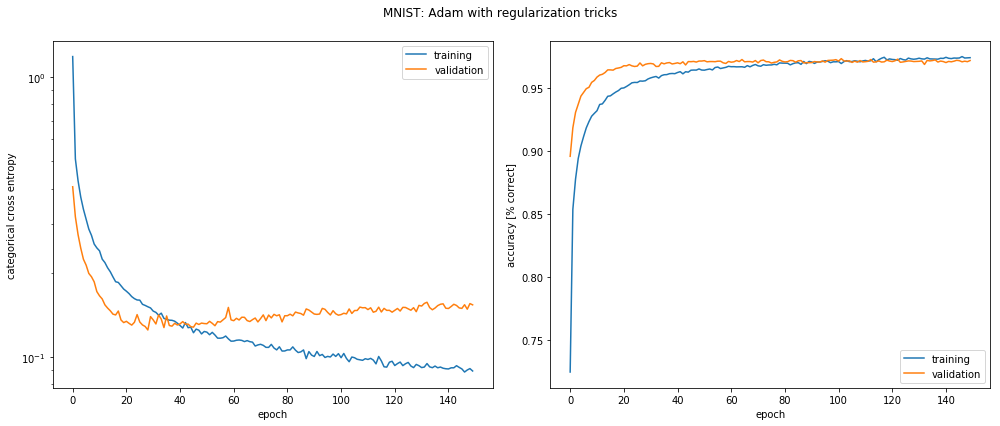

In [63]:
plot_history(history_adam_tricks, "MNIST: Adam with regularization tricks");

## Exercise 6: Convolutional neural networks (CNNs) (10 points)

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with different architectures and parameters. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples). (4 pts)
2. Plot the learning curves of the convolutional neural network for MNIST and Fashion-MNIST. (4 pts)
3. How does the CNN performance compare to the so far best performing (deep) neural network model for the two data sets? (2 sentences max.) (2 pts)

### Solution

#### Question 1.

We will implement the same architecture of the example to see the performance, as we are dealing with a CNN we need to change the input shape of our training and testing sets.

In [64]:
# Define the parameters
n_epochs = 15
row, col = 28, 28

In [65]:
(x_train, _), (x_test, _) = mnist.load_data()

# Change the input data format to fit into network
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, row, col)
    x_test = x_test.reshape(x_test.shape[0], 1, row, col)
    input_shape = (1, row, col)
else:
    x_train = x_train.reshape(x_train.shape[0], row, col, 1)
    x_test = x_test.reshape(x_test.shape[0], row, col, 1)
    input_shape = (row, col, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [66]:
(x_fashion_train, _), (x_fashion_test, _) = fashion_mnist.load_data()

# Change the input data format to fit into network
if K.image_data_format() == 'channels_first':
    x_fashion_train = x_fashion_train.reshape(x_fashion_train.shape[0], 1, row, col)
    x_fashion_test = x_fashion_test.reshape(x_fashion_test.shape[0], 1, row, col)
    input_shape = (1, row, col)
else:
    x_fashion_train = x_fashion_train.reshape(x_fashion_train.shape[0], row, col, 1)
    x_fashion_test = x_fashion_test.reshape(x_fashion_test.shape[0], row, col, 1)
    input_shape = (row, col, 1)

x_fashion_train = x_fashion_train.astype('float32')
x_fashion_test = x_fashion_test.astype('float32')
x_fashion_train /= 255
x_fashion_test /= 255

In [67]:
# Using the same architecture as the one already implemented on the examples, don't fix what is not broken

# Initialize the model
model_cnn_relu = Sequential()

# Input layer
model_cnn_relu.add(Conv2D(32, kernel_size=(1,3), activation='relu', input_shape=input_shape))

# Hidden layer
model_cnn_relu.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_cnn_relu.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn_relu.add(Dropout(0.25))
model_cnn_relu.add(Flatten())

# Hidden layer
model_cnn_relu.add(Dense(128, activation='relu'))
model_cnn_relu.add(Dropout(0.5))

# Output layer
model_cnn_relu.add(Dense(10, activation='softmax'))

# Set up the model
model_cnn_relu.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [68]:
# Fit the model to MNIST
history_cnn_relu = model_cnn_relu.fit(x_train, y_train, epochs=n_epochs, batch_size=128,
                                      validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 105s 2ms/step - loss: 0.2550 - acc: 0.9213 - val_loss: 0.0631 - val_acc: 0.9790
Epoch 2/15
60000/60000 [==============================] - 103s 2ms/step - loss: 0.0955 - acc: 0.9715 - val_loss: 0.0503 - val_acc: 0.9838
Epoch 3/15
60000/60000 [==============================] - 103s 2ms/step - loss: 0.0715 - acc: 0.9781 - val_loss: 0.0364 - val_acc: 0.9882
Epoch 4/15
60000/60000 [==============================] - 105s 2ms/step - loss: 0.0569 - acc: 0.9823 - val_loss: 0.0403 - val_acc: 0.9874
Epoch 5/15
60000/60000 [==============================] - 105s 2ms/step - loss: 0.0503 - acc: 0.9841 - val_loss: 0.0352 - val_acc: 0.9881
Epoch 6/15
60000/60000 [==============================] - 104s 2ms/step - loss: 0.0444 - acc: 0.9860 - val_loss: 0.0315 - val_acc: 0.9897
Epoch 7/15
60000/60000 [==============================] - 105s 2ms/step - loss: 0.0386 - acc: 0.9874 - val_loss: 0.0324 - 

In [69]:
# Fit the model to fashion_MNIST
history_fashion_cnn_relu = model_cnn_relu.fit(x_fashion_train, y_fashion_train, epochs=n_epochs, batch_size=128,
                                              validation_data=(x_fashion_test, y_fashion_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 98s 2ms/step - loss: 0.5852 - acc: 0.8049 - val_loss: 0.3453 - val_acc: 0.8731
Epoch 2/15
60000/60000 [==============================] - 100s 2ms/step - loss: 0.3621 - acc: 0.8697 - val_loss: 0.2989 - val_acc: 0.8905
Epoch 3/15
60000/60000 [==============================] - 103s 2ms/step - loss: 0.3160 - acc: 0.8840 - val_loss: 0.2764 - val_acc: 0.8991
Epoch 4/15
60000/60000 [==============================] - 101s 2ms/step - loss: 0.2845 - acc: 0.8954 - val_loss: 0.2566 - val_acc: 0.9059
Epoch 5/15
60000/60000 [==============================] - 100s 2ms/step - loss: 0.2648 - acc: 0.9023 - val_loss: 0.2485 - val_acc: 0.9078
Epoch 6/15
60000/60000 [==============================] - 100s 2ms/step - loss: 0.2469 - acc: 0.9076 - val_loss: 0.2437 - val_acc: 0.9107
Epoch 7/15
60000/60000 [==============================] - 100s 2ms/step - loss: 0.2339 - acc: 0.9136 - val_loss: 0.2386 - v

#### Question 2.

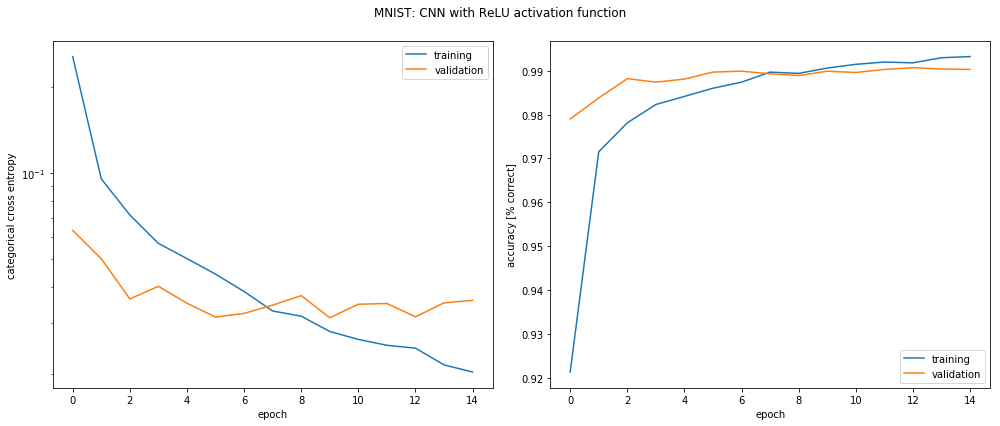

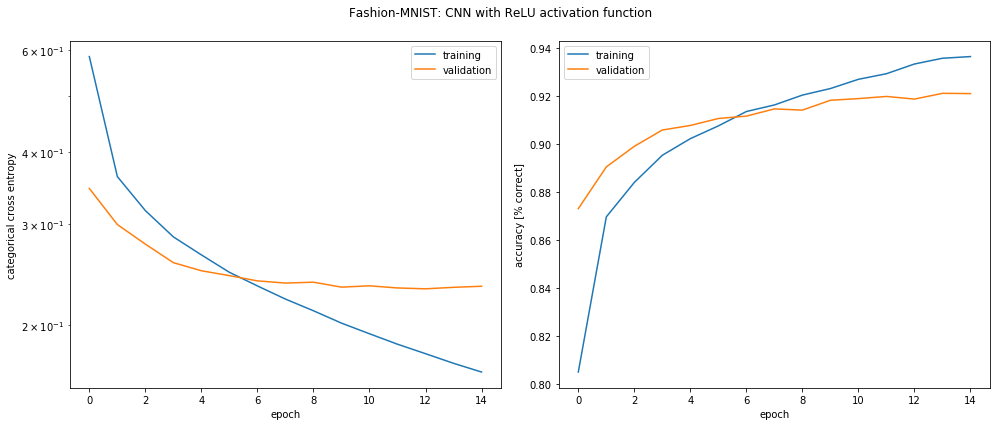

In [70]:
# Plot MNIST
plot_history(history_cnn_relu, 'MNIST: CNN with ReLU activation function')

# Plot fashion_MNIST
plot_history(history_fashion_cnn_relu, 'Fashion-MNIST: CNN with ReLU activation function');

#### Question 3.

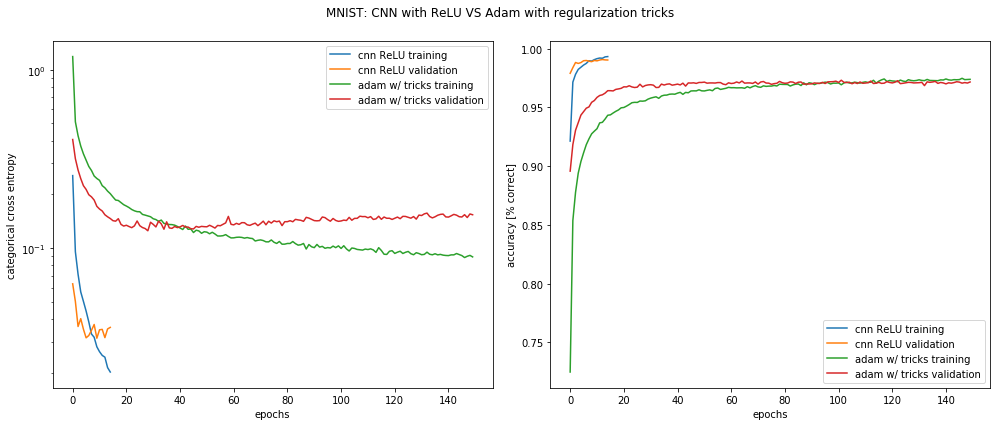

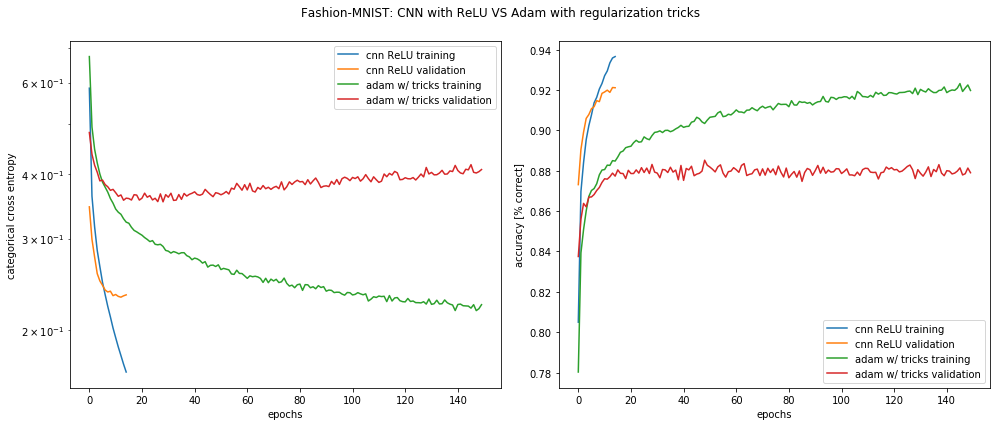

In [71]:
# Plot MNIST comparison
comparison_plot(history_cnn_relu, history_adam_tricks, 'cnn ReLU', 'adam w/ tricks',
               'MNIST: CNN with ReLU VS Adam with regularization tricks')

# Plot fashion_MNIST comparison
comparison_plot(history_fashion_cnn_relu, history_adam_fashion_tricks, 'cnn ReLU', 'adam w/ tricks',
               'Fashion-MNIST: CNN with ReLU VS Adam with regularization tricks');

Answer to question 3:

As we can see, the cnn performs even better than our other trained networks. CNN are probably the best option when it comes to image classification tasks. It also converges way faster, less epochs are needed!

## Exercise 7: Sigmoidal activation function and batch-normalization (6 points)

### Description:

In the original publication of batch normalization [Ioffe and Szegedy, 2014](https://arxiv.org/pdf/1502.03167.pdf), the authors mention a particularly beneficial effect of their method on networks with sigmoidal activation functions. This is because such networks usually suffer from saturating activations/vanishing gradients. Here we want to reproduce this behaviour (Chose either MNIST or Fashion-MNIST for this exercise).

1. Implement the same convolutional network as in the previous exercise, but using the sigmoid activation function instead of the standard choice ReLU. Train the network for a reasonable amount of time. What do you observe? (1 sentence max.) (3 pts)
2. Add batch-normalization layers to all convolutional and fully-connected layers (i.e. before each layer with learnable parameters). How does the performance change? Can the network reach the ReLU-CNN performance of the previous exercise? (1 sentence max.) (3 pts)
3. **BONUS (optional, not graded**): Investigate our initial guess that saturating activity/vanishing gradients might be the cause of this behaviour. For that, create histograms of the hidden activitions for different hidden layers for the sigmoid-CNN and the sigmoid-CNN with batch-normalization (counting over both, samples and neurons per layer). You may only chose layers with learnable parameters. What do you observe?
Hint: You can use the [keract](https://github.com/philipperemy/keract) package to access neural activation values for all layers of your network model.



### Solution:

#### Question 1

In [72]:
# Define parameters
n_epochs = 15

In [73]:
# Initialize the model
model_cnn_sig = Sequential()

# Input layer
model_cnn_sig.add(Conv2D(32, kernel_size=(1,3), activation='sigmoid', input_shape=input_shape))

# Hidden layer
model_cnn_sig.add(Conv2D(64, kernel_size=(3, 3), activation='sigmoid'))
model_cnn_sig.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn_sig.add(Dropout(0.25))
model_cnn_sig.add(Flatten())

# Hidden layer
model_cnn_sig.add(Dense(128, activation='sigmoid'))
model_cnn_sig.add(Dropout(0.5))

# Output layer
model_cnn_sig.add(Dense(10, activation='softmax'))

# Set up the model
model_cnn_sig.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [74]:
# Fit the model to MNIST
history_cnn_sig = model_cnn_sig.fit(x_train, y_train, epochs=n_epochs, batch_size=128,
                                    validation_data=(x_test, y_test));

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 139s 2ms/step - loss: 2.4216 - acc: 0.1017 - val_loss: 2.3038 - val_acc: 0.1135
Epoch 2/15
60000/60000 [==============================] - 137s 2ms/step - loss: 2.3126 - acc: 0.1038 - val_loss: 2.3047 - val_acc: 0.1028
Epoch 3/15
60000/60000 [==============================] - 137s 2ms/step - loss: 2.3044 - acc: 0.1052 - val_loss: 2.3019 - val_acc: 0.1135
Epoch 4/15
60000/60000 [==============================] - 137s 2ms/step - loss: 2.3046 - acc: 0.1068 - val_loss: 2.3020 - val_acc: 0.1135
Epoch 5/15
60000/60000 [==============================] - 139s 2ms/step - loss: 2.3040 - acc: 0.1075 - val_loss: 2.3014 - val_acc: 0.1135
Epoch 6/15
60000/60000 [==============================] - 141s 2ms/step - loss: 2.3055 - acc: 0.1075 - val_loss: 2.3018 - val_acc: 0.1028
Epoch 7/15
60000/60000 [==============================] - 146s 2ms/step - loss: 2.3037 - acc: 0.1069 - val_loss: 2.3025 - 

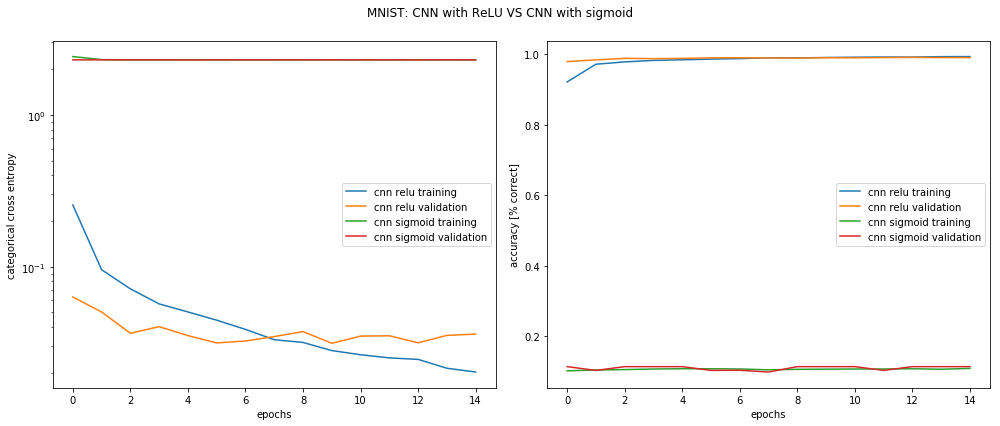

In [75]:
comparison_plot(history_cnn_relu, history_cnn_sig, 'cnn relu', 'cnn sigmoid',
                'MNIST: CNN with ReLU VS CNN with sigmoid');

Answer to question 1:

As we can expect from what we saw in class, sigmoid function has the vanishing gradient and we can see that the results due to this fenomena are quite bad.

#### Question 2.

In [76]:
# Initialize the model
model_cnn_sig = Sequential()

# Input layer
model_cnn_sig.add(BatchNormalization())
model_cnn_sig.add(Conv2D(32, kernel_size=(1,3), activation='sigmoid', input_shape=input_shape))

# Hidden layer
model_cnn_sig.add(BatchNormalization())
model_cnn_sig.add(Conv2D(64, kernel_size=(3, 3), activation='sigmoid'))
model_cnn_sig.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn_sig.add(Dropout(0.25))
model_cnn_sig.add(Flatten())

# Hidden layer
model_cnn_sig.add(BatchNormalization())
model_cnn_sig.add(Dense(128, activation='sigmoid'))
model_cnn_sig.add(Dropout(0.5))

# Output layer
model_cnn_sig.add(BatchNormalization())
model_cnn_sig.add(Dense(10, activation='softmax'))

# Set up the model
model_cnn_sig.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [78]:
# Fit the model to MNIST
history_cnn_sig_norm = model_cnn_sig.fit(x_train, y_train, epochs=n_epochs, batch_size=128,
                                         validation_data=(x_test, y_test));

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 185s 3ms/step - loss: 0.3507 - acc: 0.8955 - val_loss: 0.1049 - val_acc: 0.9678
Epoch 2/15
60000/60000 [==============================] - 177s 3ms/step - loss: 0.1235 - acc: 0.9640 - val_loss: 0.0603 - val_acc: 0.9816
Epoch 3/15
60000/60000 [==============================] - 181s 3ms/step - loss: 0.0950 - acc: 0.9721 - val_loss: 0.0551 - val_acc: 0.9830
Epoch 4/15
60000/60000 [==============================] - 188s 3ms/step - loss: 0.0806 - acc: 0.9759 - val_loss: 0.0625 - val_acc: 0.9809
Epoch 5/15
60000/60000 [==============================] - 203s 3ms/step - loss: 0.0747 - acc: 0.9773 - val_loss: 0.0428 - val_acc: 0.9859
Epoch 6/15
60000/60000 [==============================] - 200s 3ms/step - loss: 0.0684 - acc: 0.9791 - val_loss: 0.0421 - val_acc: 0.9863
Epoch 7/15
60000/60000 [==============================] - 183s 3ms/step - loss: 0.0647 - acc: 0.9802 - val_loss: 0.0471 - 

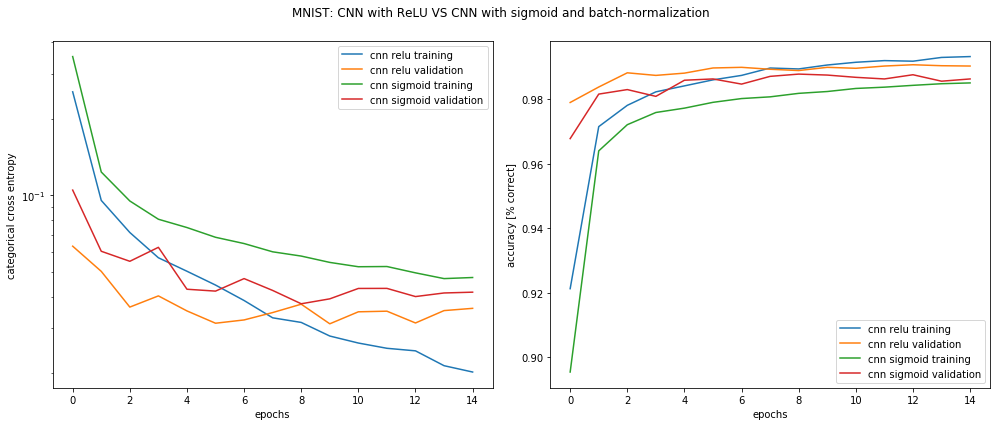

In [79]:
comparison_plot(history_cnn_relu, history_cnn_sig_norm, 'cnn relu', 'cnn sigmoid',
                'MNIST: CNN with ReLU VS CNN with sigmoid and batch-normalization');

Answer to question 2:

The performance is clearly improved compared to the one without normalization. To see if the cnn can reach the performance of our other model we need to train for multiple epochs.